In [1]:
import numpy as np
total_no_of_events = '30_events'
sdi = np.load(f'/users2/local/Venkatesh/Generated_Data/25_subjects_new/SDI/{total_no_of_events}.npz')


In [2]:
surrogate_SDI = np.load('/users2/local/Venkatesh/Generated_Data/25_subjects_new/SDI/surrogate_SDI_baseline_vanilla.npz')
empirical_SDI = np.load('/users2/local/Venkatesh/Generated_Data/25_subjects_new/SDI/SDI_baseline_vanilla.npz')

In [118]:
empirical_one_band = empirical_SDI['high_beta']
surrogate_one_band = surrogate_SDI['high_beta']
band = 'high_beta'
event_group = 2
clusters = np.load(
f"/homes/v20subra/S4B2/AutoAnnotation/dict_of_clustered_events_{total_no_of_events}.npz"
)
a = list()

a.append(clusters['0'])
a.append(clusters['1'])
a.append(clusters['2'])

index = list()
for i in sorted(np.hstack(a)):

    if i in a[0]:
        index.append(0)
    if i in a[1]:
        index.append(1)
    if i in a[2]:
        index.append(2)

empirical_one_band = empirical_SDI[f'{band}'][np.where(np.array(index) ==event_group)[0]]
surrogate_one_band = surrogate_SDI[f'{band}'][np.where(np.array(index) ==event_group)[0]]


In [119]:
empirical_one_band.shape

(7, 25, 360)

In [120]:
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu, rankdata, ttest_1samp
from tqdm.notebook import tqdm

n_subjects = 25
n_events = 7
n_roi = 360
n_surrogate = 19

test_stats = list()

for subject in tqdm(range(n_subjects)):
    event_level_p = list()


    for event in range(n_events):
        roi_level_p = list()

        
        for roi in range(n_roi):

            data_empirical = empirical_one_band[event, subject, roi]
            data_surrogate = surrogate_one_band[event, :, subject, roi]
            
            stat_test = sum(rankdata(np.abs(data_empirical - data_surrogate))*np.sign(data_empirical - data_surrogate))
            stat_test_normalized = stat_test / n_surrogate
            

            roi_level_p.append(stat_test_normalized)


        event_level_p.append(roi_level_p)

    
    test_stats.append(event_level_p)


  0%|          | 0/25 [00:00<?, ?it/s]

# Step 2: Test for effect of events

In [144]:
pvalues_step2 = list()
tvalues_step2 = list()

for sub in range(n_subjects):
    sub_wise_p = list()
    sub_wise_t = list()

    for roi in range(n_roi):
        data = np.array(test_stats)[sub, :, roi]

        t, p = ttest_1samp(data, popmean = 0)
        if t == np.inf:
            t=0
        if t == -np.inf:
            t=0

        if p == np.inf:
            p=1
        if p == -np.inf:
            p=1
        sub_wise_p.append(p)
        sub_wise_t.append(t)
    
    pvalues_step2.append(sub_wise_p)
    tvalues_step2.append(sub_wise_t)



In [146]:
thresholded_pvals.shape

(360,)

In [ ]:

from nilearn.regions import signals_to_img_labels
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
path_Glasser = "/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz"

mnitemp = fetch_icbm152_2009()

for i in range(n_subjects):

    thresholded_pvals = (np.array(pvalues_step2)[i] < 0.05) * tvalues_step2[i]
    signal = np.expand_dims(thresholded_pvals, axis =(1,2))


    U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])

    plot = plotting.plot_img_on_surf(
        U0_brain, title = f'tvalues (uncorrected) for subj {i}', threshold = 0.1)

    plt.show()


## Step 3: Second level Model

In [138]:
np.min(tvalues_step2)

0

In [ ]:
final_p, final_t = list(), []
for roi in range(n_roi):
    tvals, pvals = ttest_1samp(np.array(tvalues_step2)[:, roi], popmean=0)

    final_p.append(pvals)
    final_t.append(tvals)


Permuting 9999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


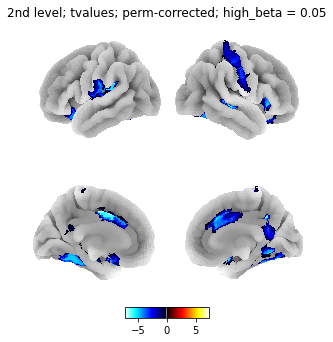

In [148]:
import mne
from nilearn.regions import signals_to_img_labels
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting

secondlevel_t, secondlevel_p, _ = mne.stats.permutation_t_test(np.array(np.array(tvalues_step2)))

path_Glasser = "/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz"

mnitemp = fetch_icbm152_2009()
mask_mni = image.load_img(mnitemp["mask"])
glasser_atlas = image.load_img(path_Glasser)

for i in range(1):

    thresholded_tvals = (np.array(secondlevel_p) < 0.05) * np.array(secondlevel_t)

    signal = np.expand_dims(thresholded_tvals, axis =(1,2))
   
    
    U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])

    plot,_ = plotting.plot_img_on_surf(
        U0_brain, title = f'2nd level; tvalues; perm-corrected; high_beta = 0.05', threshold=0.1, engine=engine)
        
    # U0_brain.to_filename('2nd_level_map_perm_corrected_stat.nii.gz')
    plot.show()

## More Stringent correction

In [ ]:
from nilearn.plotting import find_parcellation_cut_coords, plot_img_on_surf, plot_connectome

coord = find_parcellation_cut_coords(glasser_atlas, label_hemisphere = 'left')


## Neighbor-based Graph

In [ ]:
n = [3]

from sklearn.neighbors import kneighbors_graph

for i in n:
    graph = kneighbors_graph(coord, n_neighbors=i, mode = 'connectivity').toarray()
    # adjacency[0,:] 

    step2 = graph + graph.T
    adjacency = step2 - (step2>1)*1 


    signal = np.expand_dims(adjacency[27], axis =(0,2))

    U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])


    plot_img_on_surf(U0_brain, threshold = 0.1, title=f'{i} neighbors for STG')
    plt.show()

import scipy
t_obs, clusterlist, p_cluster, _ = mne.stats.permutation_cluster_1samp_test(X = np.array(tvalues_step2), adjacency =scipy.sparse.csr_matrix( adjacency), tail = 0)


final_cluster = np.array(clusterlist)[p_cluster<0.05]

for i in range(len(final_cluster)):
    zeros = np.zeros(360,)
    zeros[np.hstack(final_cluster[i])] = 1
    signal = np.expand_dims(zeros, axis =(0,2))

    U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])


    plot_img_on_surf(U0_brain, threshold = 0.1, title = f'Cluster {i}')
    plt.show()

## Radius-based Graph

In [ ]:
from sklearn.neighbors import radius_neighbors_graph


for i in n:
    graph = radius_neighbors_graph(coord, radius=5, mode = 'connectivity').toarray()
    # adjacency[0,:] 

    # step2 = graph + graph.T
    # adjacency = step2 - (step2>1)*1 


    signal = np.expand_dims(graph[27], axis =(0,2))

    U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])


    plot_img_on_surf(U0_brain, threshold = 0.1, title=f'{i} neighbors for STG')
    plt.show()


t_obs, clusterlist, p_cluster, _ = mne.stats.permutation_cluster_1samp_test(X = np.array(tvalues_step2), adjacency =scipy.sparse.csr_matrix( adjacency), tail = 0, threshold=0.01)
sum(p_cluster<0.05)

# final_cluster = np.array(clusterlist)[p_cluster<0.05]

# for i in range(len(final_cluster)):
#     zeros = np.zeros(360,)
#     zeros[np.hstack(final_cluster[i])] = 1
#     signal = np.expand_dims(zeros, axis =(0,2))

#     U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])


#     plot_img_on_surf(U0_brain, threshold = 0.1, title = f'Cluster {i}')
#     plt.show()


In [115]:
a =np.random.rand(265,1)
a[0]=0
a[23]=0
a[24]=0

In [116]:
a[np.argwhere(a==0)]=1

In [117]:
sum(a==1)

array([3])